In [4]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gundeeps23","key":"8d33ccb7402cb2fdca411c5572b763e9"}'}

In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [14]:
!mkdir -p /root/.config/kaggle
!cp kaggle.json /root/.config/kaggle/


In [15]:
!kaggle competitions download -c dog-breed-identification


 96% 664M/691M [00:03<00:00, 171MB/s]
100% 691M/691M [00:03<00:00, 209MB/s]


In [16]:
import os
os.listdir()


['.config', 'dog-breed-identification.zip', 'kaggle.json', 'sample_data']

In [17]:
!unzip -q dog-breed-identification.zip
!unzip -q train.zip
!unzip -q test.zip


unzip:  cannot find or open train.zip, train.zip.zip or train.zip.ZIP.
unzip:  cannot find or open test.zip, test.zip.zip or test.zip.ZIP.


In [18]:
labels_df = pd.read_csv("labels.csv")
print("Total images:", len(labels_df))

# Example preview
labels_df.head()


Total images: 10222


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [19]:
# Parameters
IMG_SIZE = 100  # Resizing images to 100x100 for faster training
SAMPLE_SIZE = 5000  # Reduce size for demo/training on Colab (to avoid OOM)

# Sample only a subset for speed
sample_df = labels_df.sample(SAMPLE_SIZE, random_state=42)
X = []
y = []

for i, row in sample_df.iterrows():
    img = cv2.imread("train/" + row["id"] + ".jpg")
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X.append(img)
    y.append(row["breed"])

X = np.array(X) / 255.0  # Normalize images
y = LabelBinarizer().fit_transform(y)


In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(y.shape[1], activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 106, 106,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 50, 50,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 50, 50,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 52, 52,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 25, 25,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 25, 25,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 25, 25,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 25, 25,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_3_c

 Total params: 23,833,592 (90.92 MB)

 Trainable params: 245,880 (960.47 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [22]:
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
                             height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=5)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 159ms/step - accuracy: 0.0073 - loss: 5.3950 - val_accuracy: 0.0080 - val_loss: 4.9008
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.0082 - loss: 5.1306 - val_accuracy: 0.0140 - val_loss: 4.8593
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.0080 - loss: 5.0476 - val_accuracy: 0.0120 - val_loss: 4.8237
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.0092 - loss: 4.9939 - val_accuracy: 0.0130 - val_loss: 4.8625
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.0162 - loss: 4.9552 - val_accuracy: 0.0130 - val_loss: 4.8061


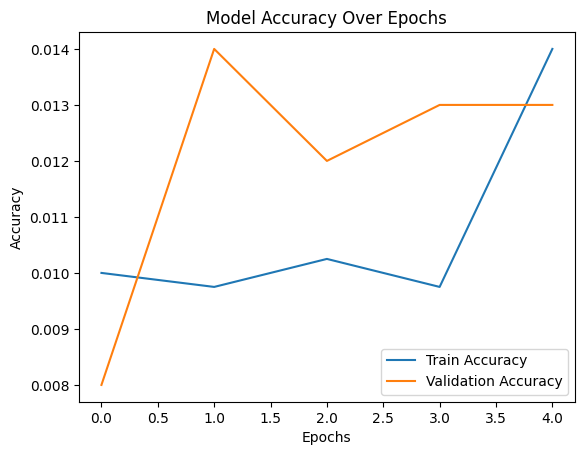

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()


In [24]:
import os
import cv2
X_test = []
test_ids = []

IMG_SIZE = 100  # must match training

for img_name in os.listdir("test"):
    img_path = os.path.join("test", img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X_test.append(img)
    test_ids.append(img_name.split('.')[0])  # get image ID without extension

X_test = np.array(X_test) / 255.0


In [25]:
predictions = model.predict(X_test, verbose=1)


324/324 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step


In [26]:
from sklearn.preprocessing import LabelBinarizer
breed_encoder = LabelBinarizer()
breed_encoder.fit(labels_df['breed'])  # reuse encoder from training

breed_names = breed_encoder.classes_

import pandas as pd
submission_df = pd.DataFrame(predictions, columns=breed_names)
submission_df.insert(0, 'id', test_ids)
submission_df.to_csv('submission.csv', index=False)

print("✅ submission.csv is ready")


✅ submission.csv is ready


In [27]:
from google.colab import files
files.download('submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>